Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# LAB9

Write a local-search algorithm (eg. an EA) able to solve the *Problem* instances 1, 2, 5, and 10 on a 1000-loci genomes, using a minimum number of fitness calls. That's all.

### Deadlines:

* Submission: Sunday, December 3 ([CET](https://www.timeanddate.com/time/zones/cet))
* Reviews: Sunday, December 10 ([CET](https://www.timeanddate.com/time/zones/cet))

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

In [3]:

import copy
from dataclasses import dataclass
from random import choice, randint
import random
import numpy as np
from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import lab9_lib as lab9


MUTATION_PROBABILITY = 0.15
TOURNAMENT_SIZE = 10
GEN_SIZE = 1000
PROB_INSTANCE = 2

In [4]:
@dataclass
class Individual:
    fitness: float
    genotype: np.ndarray

def select_parent(pop):
    pool = [choice(pop) for _ in range(TOURNAMENT_SIZE)]
    champion = max(pool, key=lambda i: i.fitness)
    return champion

def mutate(ind: Individual) -> Individual:
    offspring = copy.copy(ind)
    pos = np.random.randint(0, GEN_SIZE-1)
    offspring.genotype[pos] = 1 -  offspring.genotype[pos]
    offspring.fitness = None
    return offspring

def one_cut_xover(ind1: Individual, ind2: Individual) -> Individual:
    cut_point = randint(0, GEN_SIZE-1)
    offspring = Individual(fitness=None,
                           genotype=ind1.genotype[:cut_point] + ind2.genotype[cut_point:])
    assert len(offspring.genotype) == GEN_SIZE
    return offspring

def uniform_xover(ind1: Individual, ind2: Individual) -> Individual:
    new_genome = list()
    for l in range(len(ind1.genotype)):
      parent = random.choice(ind1,ind2)
      new_genome.append(parent.genotype[l])
    offspring = Individual(fitness=None,genotype=np.ndarray(new_genome))
    return offspring

In [5]:
# GENERAL FUNCTIONS, USEFUL FOR ALL THE APPROACHES

def binary_to_string(genome):
    return ''.join(str(g) for g in genome)

def fitness_f(genome):
    return lab9.make_problem(PROB_INSTANCE)(genome)

def local_search(params):
    population,pop_size,off_size = params
    offspring = list()
    for _ in range(off_size):
        if random.random() < MUTATION_PROBABILITY:  # self-adapt mutation probability
            # mutation  # add more clever mutations
            p = select_parent(population)
            o = mutate(p)
        else:
            # xover # add more xovers
            p1 = select_parent(population)
            p2 = select_parent(population)
            o = uniform_xover(p1, p2)
        offspring.append(o)

    for i in offspring:
        i.fitness = fitness_f(i.genotype)
    population.extend(offspring)
    population.sort(key=lambda i: i.fitness, reverse=True)
    population = population[:pop_size]
    #print("Best fitness in local_search: ",population[0].fitness)



In [291]:
from math import inf
from copy import deepcopy
import random

class Island:

    def __init__(self, population_size,off_size,max_iter):
        self.population = []
        self.best_individual = None
        self.best_fitness = None
        self.population_size = population_size
        self.max_iterations = max_iter
        self.off_size = off_size

    def gen_population(self, population : list):
        new_population = []
        for _ in range(self.population_size):
            individual = random.choice(population)
            individual.fitness = fitness_f(individual.genotype)
            new_population.append(individual)
            population.remove(individual)       #updated variable -> the picked individuals have been removed
        self.population = new_population


    # def evolve(self):
    #     for _ in range(self.max_iterations):
    #         local_search(self.population,self.population_size,self.off_size)
    #     self.best_fitness =  self.get_best_fitness()
    #     #print("Island best fitness: ",self.best_fitness)
    #     self.best_individual =  self.get_best_individual()
    #     #print("Island best ind: ",self.best_individual)
    def evolve(self):
      with ThreadPoolExecutor() as executor:
          # Parallelizza l'esecuzione di local_search
          executor.map(local_search, [(self.population, self.population_size, self.off_size)] * self.max_iterations)
          self.get_best_individual()

    def get_best_fitness(self):
        if self.best_fitness is None:
            self.best_fitness = float("-inf")
        for individual in self.population:
            fit = fitness_f(individual.genotype)
            if fit > self.best_fitness:
                self.best_fitness = fit
                self.best_individual = individual
        return self.best_fitness

    def get_best_individual(self):
        if self.best_individual is None:
            self.best_fitness = float("-inf")
        for individual in self.population:
            fit = fitness_f(individual.genotype)
            if fit > self.best_fitness:
                self.best_fitness = fit
                self.best_individual = individual
        return self.best_individual


    def __repr__(self):
        return f"Island(population={self.population}, best_individual={self.best_individual}, best_fitness={self.best_fitness})"

             ####################### end of class Island implementation #######################



def island_model(population,population_size, island_size, max_iterations,island_max_iter):
    best_fitness = float(-inf)
    best_genome = None
    best_ind = None
    history = list()


    island_count = population_size // island_size

    islands = []
    pop_cpy = deepcopy(population)

    #generation and population of islands
    for _ in range(island_count):
        island = Island(population_size=island_size,off_size=island_size*10 ,max_iter=island_max_iter)
        island.gen_population(pop_cpy)
        islands.append(island)

    for c in tqdm(range(max_iterations)):
        for island in islands:
            island.evolve()
            if island.best_individual.fitness > best_fitness:
              best_fitness = island.best_individual.fitness
              best_individual = island.best_individual
        history.append((c,best_fitness))

        if c % 2 == 0:    ##every two iterations we have a migration
            # Migrazione tra le isole
            for i in range(island_count // 2):
                #islands[i].best_individual, islands[island_count - 1 - i].best_individual = deepcopy(islands[island_count - 1 - i].best_individual), deepcopy(islands[i].best_individual)

                #random migration
                ind1_index = np.random.randint(len(islands[i].population))
                ind2_index = np.random.randint(len(islands[island_count -1 -i].population))

                tmp = deepcopy(islands[i].population[ind1_index])
                islands[i].population[ind1_index] = deepcopy(islands[island_count - 1 - i].population[ind2_index])
                islands[island_count - 1 - i].population[ind2_index] = tmp




        #find the best fitness among the several islands
        for island in islands:
            #print(island)
            if island.get_best_individual().fitness > best_fitness:
                best_fitness = island.best_individual.fitness
                best_genome = binary_to_string(island.best_individual.genotype)
                best_ind = island.best_individual

    return best_fitness, best_genome,best_ind,history






  0%|          | 0/30 [00:00<?, ?it/s]

Best fitness: 0.0
Best genome: None
Best individual:  None


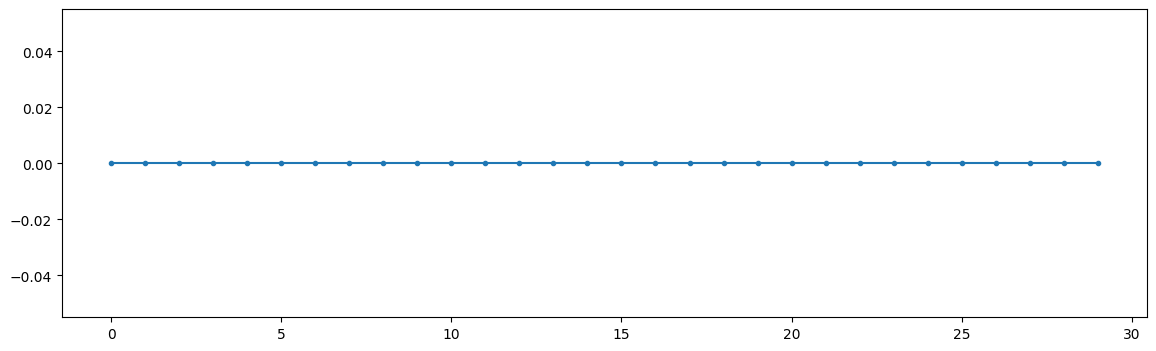

In [292]:

# define the input parameters
population_size = 100
island_size = 20
max_iterations = 30
island_max_iter = 50

# generate the initial population
population = [
    Individual(
        genotype=[choice((0, 0)) for _ in range(GEN_SIZE)],
        fitness=None,
    )
    for _ in range(population_size)
]

# run the island model
best_fitness, best_genome, best_ind,history = island_model(population, population_size, island_size, max_iterations, island_max_iter)

# print the results
print("Best fitness:", best_fitness)
print("Best genome:", best_genome)
print("Best individual: ",best_ind)

history = np.array(history)
plt.figure(figsize=(14, 4))
plt.plot(history[:, 0], history[:, 1], marker=".")


In [ ]:
#CELLULAR EA
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

#fitness class -> useful to take the count of the fitness calls
class FitnessFunction:
    def __init__(self,problem_instance):
        self.counter = 0
        self.fit = lab9.make_problem(problem_instance)
    def fit_funct(self,individual):
        self.counter +=1
        return self.fit(individual)


def create_population(rows, cols, individual_length):
    return np.random.randint(2, size=(rows, cols, individual_length))

# parent selection
def selection(population, fitness, fitnesses, x, y):
    neighbors = [(x-1, y), (x+1, y), (x, y-1), (x, y+1)]
    neighbors = [(i % population.shape[0], j % population.shape[1]) for i, j in neighbors]
    neighbor_fitnesses = [fitness(population[i, j]) for i, j in neighbors]    #lazy fitness evaluation -> in order to reduce the number of fitness calls we evaluate them only when needed
    
    return population[neighbors[np.argmax(neighbor_fitnesses)]]



# mutation or xover are applied
def mutation_or_xover(individual, mutation_rate,parent1, parent2):
        if np.random.random() < mutation_rate:
            offspring = copy.copy(individual)
            pos = randint(0, GEN_SIZE-1)
            offspring[pos] = 1 -  offspring[pos]
        else:
            crossover_index = np.random.randint(len(parent1))
            offspring = np.concatenate((parent1[:crossover_index], parent2[crossover_index:]))
        return offspring

# the algorithm is run here -> look at how the double concatenated for force a 2D lattice
def cellular_genetic_algorithm(population, fitness, selection, mutation_or_xover, mutation_rate, generations,rows,cols):
    fitnesses = np.zeros((rows,cols))
    history = list()
    best_fitness = None
    best_genome = None
    for c in tqdm(range(generations)):
        for i in range(population.shape[0]):
            for j in range(population.shape[1]):
                parent1 = population[i, j]
                parent2 = selection(population, fitness, fitnesses,i, j)
                child = mutation_or_xover(parent1, mutation_rate,parent1,parent2)
                population[i, j] = child
                fitnesses[i, j] = fitness(child)
                if best_fitness == None or fitnesses[i,j] > best_fitness:
                  best_fitness = fitnesses[i,j]
                  best_genome = population[i,j]

        history.append((c,best_fitness))
    return best_fitness,best_genome,history

#main below
rows = 200
cols = 200
individual_length = 1000
mutation_rate = 0.3
generations = 10
problem_instance = 2

fitness_function = FitnessFunction(problem_instance)

#generation of the population
population = create_population(rows, cols, individual_length)

#execution of the algorithm
best_fitness,best_genome,history = cellular_genetic_algorithm(population, fitness_function.fit_funct, selection, mutation_or_xover, mutation_rate, generations,rows,cols)


print('Miglior individuo:', best_genome)
print("Migliore fitness: ",best_fitness)
print("Numero di fitness call: ",fitness_function.counter)

history = np.array(history)
plt.figure(figsize=(14, 4))
plt.plot(history[:, 0], history[:, 1], marker=".")


  0%|          | 0/10 [00:00<?, ?it/s]

In [288]:
## you should try with all the possibile optimisations in order to creare a population with a fitness as much closer to 100% as possible


#the genome is fixed (0 and 1 sequence)

#define the mutation

#define the parent selection -> apply the optimisations

#define the survival selection -> apply the optimisations



In [293]:
# fitness = lab9_lib.make_problem(10)
# for n in range(10):
#     ind = choices([0, 1], k=50)
#     print(f"{''.join(str(g) for g in ind)}: {fitness(ind):.2%}")

# print(fitness.calls)
